In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
df = pd.read_csv('../datasets/movies.csv')
df.head(n=3)

id     imdb_id                    title  \
0  414906   tt1877830               The Batman   
1  634649  tt10872600  Spider-Man: No Way Home   
2  799876  tt14114802               The Outfit   

                             genres original_language  \
0            Crime-Mystery-Thriller                en   
1  Action-Adventure-Science Fiction                en   
2              Drama-Thriller-Crime                en   

                                            overview  popularity  \
0  In his second year of fighting crime Batman un...    8195.597   
1  Peter Parker is unmasked and no longer able to...    4716.995   
2  Leonard is an English tailor who used to craft...    2752.077   

                                production_companies release_date     budget  \
0  6th & Idaho-Dylan Clark Productions-DC Films-W...   2022-03-01  185000000   
1   Marvel Studios-Pascal Pictures-Columbia Pictures   2021-12-15  200000000   
2  Focus Features-FilmNation Entertainment-Unifie...   2022-02-25          0   

   ...  runtime    status                                  tagline  \
0  ...    176.0  Released                        Unmask the truth.   
1  ...    148.0  Released                The Multiverse unleashed.   
2  ...    105.0  Released  Everyone has something up their sleeve.   

  vote_average  vote_count                                            credits  \
0          7.8        4165  Robert Pattinson-Zoë Kravitz-Paul Dano-Jeffrey...   
1          8.1       12300  Tom Holland-Zendaya-Benedict Cumberbatch-Jacob...   
2          7.0         161  Mark Rylance-Zoey Deutch-Dylan O'Brien-Johnny ...   

                                            keywords  \
0  crime fighter-secret identity-nightclub-politi...   
1  new york city-loss of loved one-showdown-secre...   
2  chicago illinois-murder-organized crime-mobste...   

                        poster_path                     backdrop_path  \
0  /74xTEgt7R36Fpooo50r9T25onhq.jpg  /tRS6jvPM9qPrrnx2KRp3ew96Yot.jpg   
1  /1g0dhYtq4irTY1GPXvft6k4YLjm.jpg  /iQFcwSGbZXMkeyKrxbPnwnRo5fl.jpg   
2  /ieOVuwnoFC49m7bekmdQ4AynciS.jpg  /2n95p9isIi1LYTscTcGytlI4zYd.jpg   

                                     recommendations  
0  335787-508947-696806-777270-833425-718032-5050...  
1  646380-624860-568124-524434-580489-425909-4766...  
2  294793-760104-628900-606402-406759-811631-8799...  

[3 rows x 21 columns]

In [9]:
print(df.columns.tolist())



['id', 'imdb_id', 'title', 'genres', 'original_language', 'overview', 'popularity', 'production_companies', 'release_date', 'budget', 'revenue', 'runtime', 'status', 'tagline', 'vote_average', 'vote_count', 'credits', 'keywords', 'poster_path', 'backdrop_path', 'recommendations']


<h3>Filtering and feature extration</h3>

In [10]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/klebervasconcelos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/klebervasconcelos/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/klebervasconcelos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def lemmatization():
    #Filling the missing values with empty string
    df['overview'] = df['overview'].fillna('')

    #Tokenizing the words (splitting the string words )
    df['overview'] = df['overview'].str.lower().apply(word_tokenize)
    
    #Setting the pos tag for each word
    df['overview'] = df['overview'].apply(nltk.tag.pos_tag)


    #Converting pos to wordnet format
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
        
    #Applying the function to each word in each review
    df['overview']= df['overview'].apply(lambda x: [(word, get_wordnet_pos(pos)) for (word, pos) in x])

    #Lemmatizing each word
    lemmatizer = WordNetLemmatizer()
    
    df['overview'] = df['overview'].apply(lambda x: [lemmatizer.lemmatize(word, pos) for (word, pos) in x])

    #Joining the words back to string
    df['overview'] = df['overview'].apply(lambda x:''.join(x))


In [71]:
df.drop_duplicates(inplace=True, ignore_index=True)
#df = df.groupby('title').first().reset_index()
df.fillna(value={i: ' ' for i in ['overview', 'genres', 'keywords', 'credits']}, inplace=True)

# lambda func for str split join
strOp= lambda x: ' '.join(x.split('-'))

df.overview = df.overview + df.keywords.apply(strOp) + df.genres.apply(strOp) + df.credits.apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:3]))
 
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

display(pd.DataFrame(
    tfidf_matrix[:10, 7000:7070].toarray(),
    columns= tfidf.get_feature_names_out()[7000:7070],
    index = df.title[:10]).round())

print(tfidf_matrix.shape)

9partnerjerryleearereadytoretirefromthepoliceforce  \
title                                                                             
The Batman                                                                 0.0    
Spider-Man: No Way Home                                                    0.0    
The Outfit                                                                 0.0    
Turning Red                                                                0.0    
Sonic the Hedgehog 2                                                       0.0    
Yaksha: Ruthless Operations                                                0.0    
Moonfall                                                                   0.0    
Uncharted                                                                  0.0    
All the Old Knives                                                         0.0    
Blacklight                                                                 0.0    

                             9peopleincludingjuzaburokokutaya  \
title                                                           
The Batman                                                0.0   
Spider-Man: No Way Home                                   0.0   
The Outfit                                                0.0   
Turning Red                                               0.0   
Sonic the Hedgehog 2                                      0.0   
Yaksha: Ruthless Operations                               0.0   
Moonfall                                                  0.0   
Uncharted                                                 0.0   
All the Old Knives                                        0.0   
Blacklight                                                0.0   

                             9peopleperformedassilhouettesinthewindows  \
title                                                                    
The Batman                                                         0.0   
Spider-Man: No Way Home                                            0.0   
The Outfit                                                         0.0   
Turning Red                                                        0.0   
Sonic the Hedgehog 2                                               0.0   
Yaksha: Ruthless Operations                                        0.0   
Moonfall                                                           0.0   
Uncharted                                                          0.0   
All the Old Knives                                                 0.0   
Blacklight                                                         0.0   

                             9pmestforaworldwidevirtualviewingofthe1981samraimiclassictheevildeadwithlivecommentarythroughoutbycampbellhimself  \
title                                                                                                                                            
The Batman                                                                 0.0                                                                   
Spider-Man: No Way Home                                                    0.0                                                                   
The Outfit                                                                 0.0                                                                   
Turning Red                                                                0.0                                                                   
Sonic the Hedgehog 2                                                       0.0                                                                   
Yaksha: Ruthless Operations                                                0.0                                                                   
Moonfall                                                                   0.0                                                                   
Uncharted                                       

(230159, 1387288)


<h3>Recommender Function</h3>

In [72]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, n):
    idx = []
    for i in range(len(title)):

        # Get the index of the movie that matches the title

        idx.append(df.index[df['title'] == title[i]][0])
        print(idx)
        # show given movie poster
        try:
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{df.loc[idx[i], "poster_path"]}')
            plt.imshow(a)
            plt.axis('off')
            plt.title(title[i])
            plt.show()
        except:pass
        
    print('Recommendations\n')

    def harmonic_mean(cosine_similarity_1, cosine_similarity_2):
        return 2 / ((1 / cosine_similarity_1) + (1 / cosine_similarity_2))


    def geometric_mean(cosine_similarity_1, cosine_similarity_2):
        return np.sqrt(cosine_similarity_1 * cosine_similarity_2)



    # Get the similarity score of both movies
    movie_1_score =  cosine_similarity(tfidf_matrix, tfidf_matrix[idx[0]])
    movie_2_score =  cosine_similarity(tfidf_matrix, tfidf_matrix[idx[1]])
 

    # Calculating the average score of the two movies
    # avg_similarity_score = np.mean([movie_1_score, movie_2_score], axis=0)
    # avg_similarity_score = harmonic_mean(movie_1_score, movie_2_score)
    avg_similarity_score = geometric_mean(movie_1_score, movie_2_score)


    print(avg_similarity_score)

    sim_scores = list(enumerate(avg_similarity_score))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    print(sim_scores)

    # #export sim_scores as txt
    # with open('sim_scores.txt', 'w') as f:
    #     for i in sim_scores:
    #         f.write(str(i[0]) + '\n')

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:20]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = df.iloc[movie_indices]
    
    # show reco. movie posters
    fig, ax = plt.subplots(5, 4, figsize=(15,20))
    ax=ax.flatten()
    for i, j in enumerate(result.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(result.iloc[i].title,)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except: pass
    fig.tight_layout()
    fig.show()

[958]


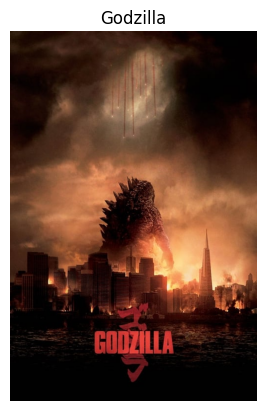

[958, 7234]


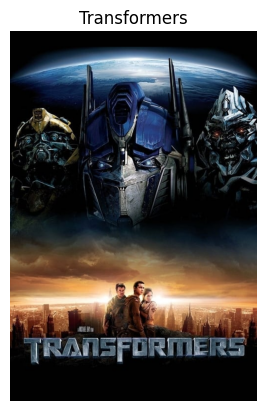

Recommendations

[[0.03269864]
 [0.03363703]
 [0.        ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
[(958, array([0.22687678])), (7234, array([0.22687678])), (1943, array([0.13484845])), (3695, array([0.11128691])), (1569, array([0.09795721])), (12495, array([0.08855886])), (1817, array([0.08804697])), (5155, array([0.08653373])), (5896, array([0.08497804])), (99427, array([0.08017836])), (222577, array([0.08017836])), (825, array([0.0799612])), (3646, array([0.0799604])), (120019, array([0.07957771])), (202467, array([0.07957771])), (606, array([0.07943843])), (764, array([0.07889344])), (2504, array([0.07865891])), (27126, array([0.0780644])), (1454, array([0.07804904])), (230, array([0.07764234])), (387, array([0.07692446])), (1847, array([0.07683296])), (2270, array([0.07617675])), (47895, array([0.07473069])), (23070, array([0.07357533])), (33009, array([0.07323082])), (1132, array([0.07318977])), (21084, array([0.0730482])), (167546, array([0.0730482])), (11000, array([0.0

/var/folders/8b/nlm7fd7x3qs60ymkbrb9srdm0000gn/T/ipykernel_2024/4160200865.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


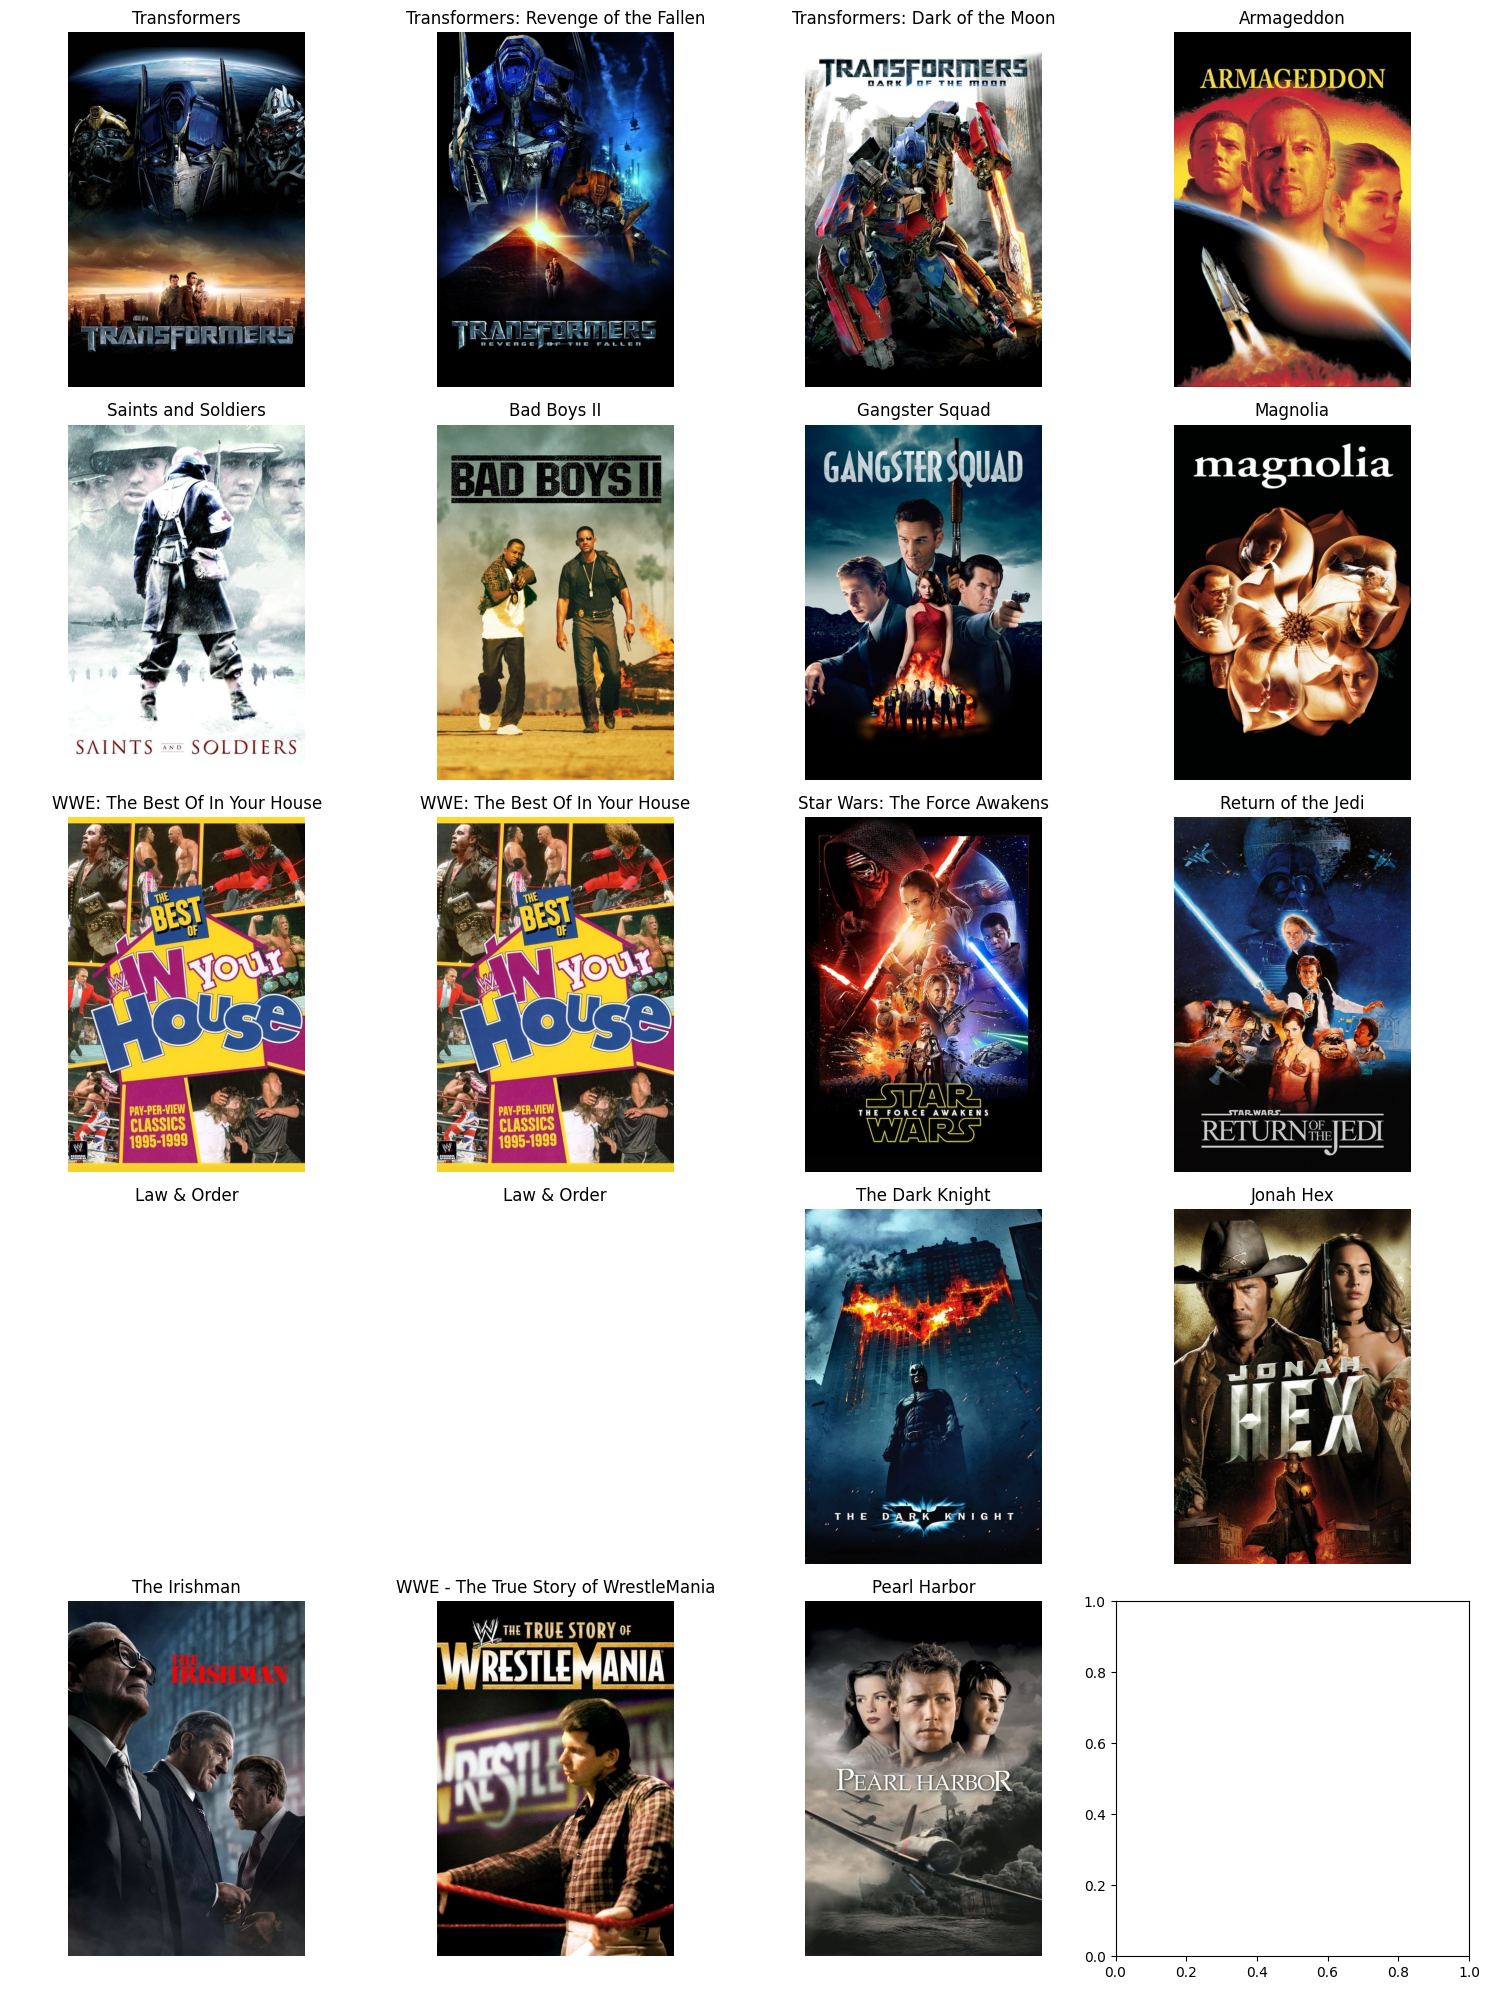

In [73]:
movies = ['Godzilla', 'Transformers']
get_recommendations(movies, len(movies))